# Tutorial 3: Accessing web-hosted geo-data and clustering

In this tutorial, we will work with the Flickr photo database to better understand how people interact with specific land use types. We will learn how to extract information from Flickr, how you can explore and visualize this, and how to use it for some basic analysis. We will also learn how to retrieve features from a web service, how to analyze information in aggregate, and how to perform K-Means clustering.

### Important before we start
---
This is a 1-week exercise rather than the 2-week exercises of the previous weeks. For that reason, it contains more pre-filled code. You will have the chance to experiment a little bit for some questions for those that find the coding too easy, though.

⚠️**Questions are indicated in full bold face.** They should be filled in on Canvas. There are 9 questions in total, all with open answers. We suggest keeping answers brief, the questions are mostly to guide your thinking about what is important in each section. Questions marked with '⚠️' are for slightly longer questions with open coding problems, i.e. giving you a chance to experiment a bit with what you've learned, and to come up with some new ideas.

⚠️ Make sure that you save this file before you continue, else you will lose everything. To do so, go to Bestand/File and click on Een kopie opslaan in Drive/Save a Copy on Drive! Now, rename the file into Week4_Tutorial1.ipynb. You can do so by clicking on the name in the top of this screen.


## Learning Objectives
<hr>

- To know how to extract data from Flickr using an API.
- To know how to combine different spatial datasets to gain additional insights.
- To understand how we can access publicly-available geo-data from APIs
- To know how to clean and prepare raw data for analysis.
- To visualize point data and aggregated data in a meaningful way.
- To know how to cluster geospatial information using K-Means clustering

## 1.Introducing the packages
<hr>

The following packages are noteworthy in this tutorial:

[**flickrapi**](https://stuvel.eu/flickrapi-doc/index.html) is a Python interface to the Flickr API. It includes support for authorized and non-authorized access, uploading and replacing photos, and all Flickr API functions.

[**Pandas**](https://pandas.pydata.org/docs/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

[**GeoPandas**](https://geopandas.org/) is a Python package that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

[**contextily**](https://contextily.readthedocs.io/en/latest/) Contextily provides one-line basemap loading for plotting in Python, which makes it much easier to add context to your visualized spatial data.

[**owslib**](https://owslib.readthedocs.io/en/latest/) owslib is a package that wraps requests to spatial API endpoints, such as web feature services, making it easier to load spatial data from APIs.

[**scikit-learn**](https://scikit-learn.org/stable/) is a Python package for statistical learning that is built on the general NumPy ecosystem. It is the most-used package for classical machine learning.

*We will first need to install these packages in the cell below. Uncomment them to make sure we can pip install them*

In [ ]:
!pip -q install flickrapi osmnx contextily geopandas fiona owslib

Now we will import these packages in the cell below:

In [ ]:
from datetime import datetime
from matplotlib import pyplot as plt
import json # This package is for reading the responses of a web request

import flickrapi
import contextily as cx
import osmnx as ox
import numpy as np
import pandas as pd
import geopandas as gpd

import shapely
from owslib.wfs import WebFeatureService # This package makes it easier to formulate web requests

from sklearn.cluster import KMeans

## 2. Extract data from Flickr
<hr>

To extract data from Flicker, we will use their **API**. This is an acronym for application programming interface. It is a software intermediary that allows two applications to talk to each other. APIs are an accessible way to extract and share data within and across organizations. APIs are all around us. Every time you use a rideshare app, send a mobile payment, or change the thermostat temperature from your phone, you’re using an API.

However, before we can access this **API**, we need to take a few steps. Most importantly, we need to register ourselves on the [Flickr](https://www.flickr.com/) portal. To do so, we need to register, as explained in the video clip below:

<img src="https://github.com/ElcoK/BigData_AED/blob/main/_static/images/Flickr_registration.gif?raw=1" class="bg-primary mb-1">
<br>

Now, the next step is to access the API. You can now login on the website of [Flickr](https://www.flickr.com/), and go to the **API** part of the [website](https://www.flickr.com/services/apps/create/apply/?).

Now click on `APPLY FOR A NON-COMMERCIAL KEY` and just fill in some information about the course. The name of the App can be something random and related to our big data course, and you just need to fill in two lines of text to describe what you want to do. As soon as you click `SUBMIT`, you will see a generated **api_key** and an **api_secret**. Fill those in below.

In [ ]:
api_key = 'b88e5f1bcf50b53c3ffcab715453b66f'
api_secret='6c1b62329c5a5633'

flickr = flickrapi.FlickrAPI(api_key, api_secret, cache=True)

### Prepare data extraction

Before we get started with the extraction of data, we need to specify again an area of interest we want to focus on. In the cell below, you will now read "Ameland, The Netherlands". Change this to any random or municipality in the Netherlands that (1) you can think of and (2) will work.

In some cases, the function does not recognize the location. You could either try a different phrasing or try a different location. Many parts of the Netherlands should work. It is also fine to use an area outside of the Netherlands. I would make sure to not make it too large, as it will take a long time to extract the photos.

In [ ]:
place_name = "Ameland, The Netherlands"
area = ox.geocode_to_gdf(place_name)

Now let us visualize the bounding box of the area, similar to some of our previous tutorials.

<ipython-input-5-cce74c12e76b>:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  size = int(area_to_check.area/1e6)


Text(0.5, 1.0, 'Ameland, The Netherlands. Total area: 160 km2')

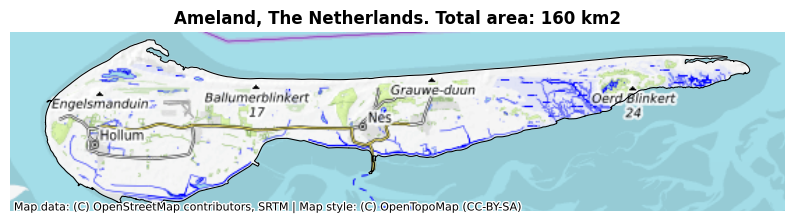

In [ ]:
area_to_check = area.to_crs(epsg=3857)
ax = area_to_check.plot(figsize=(10, 10), color="none", edgecolor="k", linewidth=0.75)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=11, source=cx.providers.OpenTopoMap) #depending on the size of your area, you may need to change the zoom level if you run into an error.
size = int(area_to_check.area/1e6)

ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

### Data extraction

To extract the metadata of the photos from Flickr, we are going to use the `.walk()` function. This function will return a list of photos matching some criteria. It allows you to search photos based on location, date, tag and so on.

In our case, we are state that we want to find all photos, no matter how they are tagged. This is defined through `tag_mode=all`. Moreover, as you will see, we also specify that we want some extra information. More specifically, we ask for the `geo(location)`, `tags`, `date_taken` and the `url_m` of a photo.

We use a bounding box `bbox` to make sure we only select photos from our region of interest. The input requires our bounding box to me in a string format. So let's do that first.

In [ ]:
bbox_string = ",".join([str(x) for x in area.bounds.values[0]])

And now we can extract all the photos. We collect all of them in a list, through the `.append()` function

In [ ]:
collect_pictures = []
for photo in flickr.walk(tag_mode='any',
                         #tags='nature',
                         bbox=bbox_string,extras='geo,tags,date_taken,url_m'):

    get_attributes = photo.attrib
    collect_pictures.append([get_attributes['id'],
                             get_attributes['owner'],
                             get_attributes['datetaken'],
                             get_attributes['tags'],
                             get_attributes['latitude'],
                             get_attributes['longitude']])

In [ ]:
len(collect_pictures)

6900

## 3. Explore the data
<hr>
Now we have extracted the data and, let's explore (and clean) this data a bit more. The convenient thing of having everything stored in a list, is that we can easily turn this into a pandas DataFrame.

In [ ]:
df = pd.DataFrame(collect_pictures,columns=['id','owner','datetaken','tags','latitude','longitude'])

In [ ]:
df.to_csv('Ameland_Flickr.csv')

Now let's explore the data a little bit:

In [ ]:
df.head(20)

,id,owner,datetaken,tags,latitude,longitude
0,54030466890,63991153@N00,2024-08-29 14:30:05,lighthouse fjoertoer vuurtoren ameland amelân ...,53.449381,5.623358
1,54026176572,10485938@N00,2024-09-25 15:23:19,,53.460082,5.777918
2,54025875198,63991153@N00,2024-08-29 13:56:03,beach strân strand plage people summer four do...,53.445075,5.613788
3,54025748630,11288822@N04,2024-09-11 10:04:53,,53.450711,5.631969
4,54025305871,11288822@N04,2024-09-11 08:41:10,,53.449844,5.634163
5,54025539353,11288822@N04,2024-09-11 10:04:24,,53.450688,5.631980
6,54025636624,11288822@N04,2024-09-11 10:48:54,,53.459769,5.685588
7,54024295987,11288822@N04,2024-09-11 10:04:24,,53.450688,5.631980
8,54025525869,11288822@N04,2024-09-11 10:04:53,,53.450711,5.631969
9,54025193331,11288822@N04,2024-09-11 08:41:10,,53.449844,5.634163


And let's see if everything is stored in a format in which we can work with:

In [ ]:
df.dtypes

,0
id,object
owner,object
datetaken,object
tags,object
latitude,object
longitude,object


We would expect floating values for the **latitude** and **longitude**, and a *datetime* object for the **datetaken**. Let's have a look how these are stored:

In [ ]:
df.longitude.iloc[0]

'5.623358'

Aha! Strings. It will be difficult to convert strings into proper geometries, so let's convert these columns to floating values, and convert them to **points** using `pygeos.points()`. As you will see, we use a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) to do so. The input for `pygeos.points()` is a list or numpy array, in which each element contains a *longitude* and a *latitude*. To make sure we have that, we create this `list` using the [zip](https://docs.python.org/3.3/library/functions.html#zip) function in Python.


<b>Question 1: As all the data is stored in strings, its pretty difficult to do something with the information straight away. Please provide the lines of code that you have written to convert the geo-information (lattitude and longitude) into actual coordinates and also provide the lines of code that you have written to convert the dates to a datetime object. Explain the lines of code.</b>

In [ ]:
# Make sure your columns are of the right variable type by converting
# Then, use Shapely to make point objects from the latitude/longitude columns

Now let's convert the **datetaken** column into a *datetime* type, so we can extract specific years or days. To do so, we will make use of the `lambda` and `apply` functions, and use the `fromisoformat()` function from within the **datetime** package.

In [ ]:
df['datetaken'] = df.datetaken.XXXX(XXXX x : datetime.XXXX(x))
df['year'] = df.datetaken.dt.year
df['month'] = df.datetaken.dt.strftime('%b')
df['month'] = df.datetaken.dt.month # Numeric
df['month_year'] = df['datetaken'].dt.to_period('M')

NameError: name 'df' is not defined

In [ ]:
df.datetaken.dt.year

,datetaken
0,2024
1,2024
2,2024
3,2024
4,2024
...,...
6895,2024
6896,2024
6897,2024
6898,2024


Now we have the dates in the correct format, we can plot a figure to identify when most of the photos have been taken/uploaded.

<Axes: xlabel='year'>

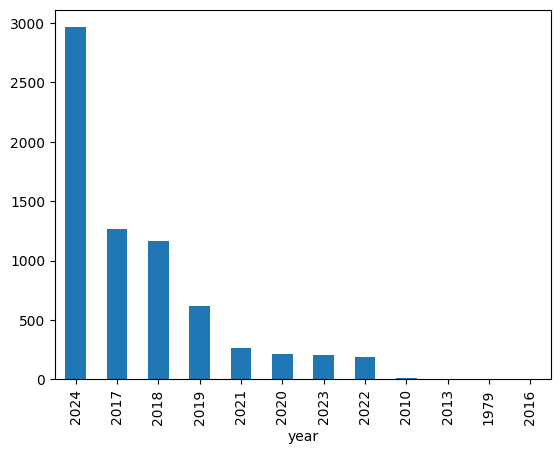

In [ ]:
df.year.value_counts().plot(kind='bar')

As we are dealing with spatial data, it would be nice to plot this information on a map. To do so, we convert our `pandas.DataFrame` into a `geopandas.GeoDataFrame`. Moreover, we have to specify the coordinate reference system. Given that we have a global dataset, it makes most sense to use **epsg:4326**, the world geodetic system.

In [ ]:
gdf = gpd.GeoDataFrame(df.copy())
gdf.crs = 'epsg:4326'

In [ ]:
gdf

,id,owner,datetaken,tags,latitude,longitude,geometry,year,month,month_year
0,54030466890,63991153@N00,2024-08-29 14:30:05,lighthouse fjoertoer vuurtoren ameland amelân ...,53.449381,5.623358,POINT (5.62336 53.44938),2024,8,2024-08
1,54026176572,10485938@N00,2024-09-25 15:23:19,,53.460082,5.777918,POINT (5.77792 53.46008),2024,9,2024-09
2,54025875198,63991153@N00,2024-08-29 13:56:03,beach strân strand plage people summer four do...,53.445075,5.613788,POINT (5.61379 53.44508),2024,8,2024-08
3,54025748630,11288822@N04,2024-09-11 10:04:53,,53.450711,5.631969,POINT (5.63197 53.45071),2024,9,2024-09
4,54025305871,11288822@N04,2024-09-11 08:41:10,,53.449844,5.634163,POINT (5.63416 53.44984),2024,9,2024-09
...,...,...,...,...,...,...,...,...,...,...
6895,53994026908,64644540@N03,2024-09-11 16:30:06,,53.448263,5.618277,POINT (5.61828 53.44826),2024,9,2024-09
6896,53993792596,64644540@N03,2024-09-12 10:29:01,,53.427294,5.644697,POINT (5.64470 53.42729),2024,9,2024-09
6897,53994026418,64644540@N03,2024-09-12 10:41:41,,53.424955,5.674044,POINT (5.67404 53.42495),2024,9,2024-09
6898,53994215850,64644540@N03,2024-09-12 10:41:34,,53.424955,5.674044,POINT (5.67404 53.42495),2024,9,2024-09


Text(0.5, 1.0, '')

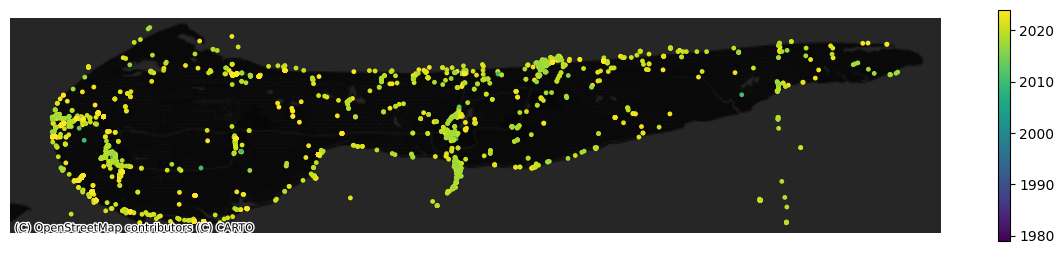

In [ ]:
gdf_to_plot = gdf.to_crs(epsg=3857)

ax = gdf_to_plot.plot(column='year',figsize=(15, 3),legend=True, markersize=6)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=11, source=cx.providers.CartoDB.DarkMatter) #depending on the size of your area, you may need to change the zoom level if you run into an error.

ax.set_title("")

<b>Question 2: Describe the plot of the amount of photos over per year (or per month) and the map. Do you already notice specific patterns. Is there something already that may influence our results later on?</b>

Let's have a look how all these photos are tagged. And whether we can actually do something with this information.

In [ ]:
gdf['tags']

,tags
0,lighthouse fjoertoer vuurtoren ameland amelân ...
1,
2,beach strân strand plage people summer four do...
3,
4,
...,...
6895,
6896,
6897,
6898,


This looks like a mess. It seems we have some work to do to be able to use some of this. Lets get an overview of all the tags and get an idea how often certain tags are used. Write some code to find the most common tags from all of the rows, then print the most popular tags.

In [ ]:
# TIP: You need to split the tags of each individual, store them somewhere, then count and sort them.

So we see that quite a lot of the tags don't really say much about the area or why people might visit the area. Let's give it a go by just trying to see how many pictures are tagged in something linked to nature. Add more words if you believe you can identify more in the previous overview.

In [ ]:
matches = ["seehund", "zeehond","vis","wadden",
            "natuur","nature","natur",
            "landschaft",
            "strand","beach","zee","sea","meer",
            "bos","forest",
            "animal","bird","vogel","dier"]

def find_tags(row):
    overlap = set(row.split()).intersection(set(matches))

    if len(overlap) :
        return 'yes'

gdf['nature'] = gdf.tags.apply(lambda x: find_tags(x))
len(gdf.loc[gdf.nature=='yes'])

**Question 3: What do the `apply` and `lambda` functions do in the above code? Why is this way of running functions on a dataframe better than iterating over rows?**

Let's only plot those points on a map

Text(0.5, 1.0, '')

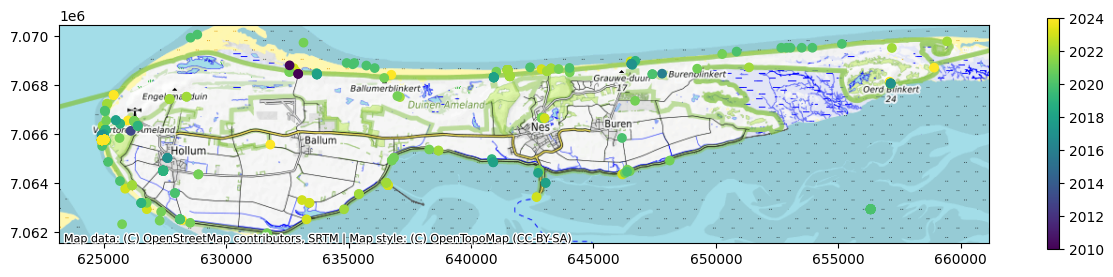

In [ ]:
gdf_to_plot = gdf.to_crs(epsg=3857)
gdf_to_plot = gdf_to_plot.loc[gdf_to_plot.nature == 'yes']
gdf_to_plot.reset_index(drop=True,inplace=True)

ax = gdf_to_plot.plot(column='year',figsize=(15, 3),legend=True)
cx.add_basemap(ax, source=cx.providers.OpenTopoMap, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.

ax.set_title("")

⚠️ Take your time and play around with the tags. Make your own sets if you like based on different tags.

<b>Question 4: Report the tag sets that you made, along with the number of photos that each tag set belongs to. Why did you make the tag sets you made?</b>

What we also noticed is that some users seems to upload quite a lot of pictures. Let's have a look at the amount of unique users in this area:

In [ ]:
gdf_to_plot.owner.value_counts().head()

,count
owner,
63991153@N00,186
57755771@N05,40
20829994@N04,32
146166548@N02,31
88330064@N07,27


And have a look at one of the users with the most pictures

In [ ]:
# Select only those rows belonging to owners with a lot of photos

,id,owner,datetaken,tags,latitude,longitude,geometry,year,month,month_year,nature
0,54025875198,63991153@N00,2024-08-29 13:56:03,beach strân strand plage people summer four do...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes
1,54023416616,63991153@N00,2024-08-29 13:51:38,backlight tsjinljocht gegenlicht tegenlicht be...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes
2,54020292802,63991153@N00,2024-08-29 13:24:45,poles peallen palen pfähle pfahl peal pole str...,53.445196,5.614764,POINT (625032.669 7065775.476),2024,8,2024-08,yes
3,53992640423,63991153@N00,2024-08-29 13:36:52,beach strân strand amelân ameland netherlands ...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes
4,53988432645,63991153@N00,2024-08-29 13:52:52,amelân ameland fryslân friesland beach strân s...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes
...,...,...,...,...,...,...,...,...,...,...,...
462,54023416616,63991153@N00,2024-08-29 13:51:38,backlight tsjinljocht gegenlicht tegenlicht be...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes
463,54020292802,63991153@N00,2024-08-29 13:24:45,poles peallen palen pfähle pfahl peal pole str...,53.445196,5.614764,POINT (625032.669 7065775.476),2024,8,2024-08,yes
464,54025875198,63991153@N00,2024-08-29 13:56:03,beach strân strand plage people summer four do...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes
465,54023416616,63991153@N00,2024-08-29 13:51:38,backlight tsjinljocht gegenlicht tegenlicht be...,53.445075,5.613788,POINT (624924.022 7065752.861),2024,8,2024-08,yes


Ok, so it seems that we have several users that dominate the amount of uploads. If we want to say something about the preference of locations to visit, we might have to compensate for this. To do so, we can make use of the groupby function. Which columns would you like to use to make sure you still keep enough unique entries? And which groupby functions will you choose to group on? First, last, mean?

In [ ]:
# Have a look at the Pandas groupby function documentation to figure out how this works
# Know that you can group by multiple columns - and know that grouping by only the user will have downsides!
gdf_unique = ...

<b>Question 5: Please provide the lines of code that you have written to reduce the potential double-counting of the same user on the same location, and explain the code and the rationale behind it.</b>


## 4. Grid aggregation of data
<hr>

As it is pretty difficult to see any patterns on the maps above, let's try to aggregate some of this information and see if this helps us to better understand why people choose to visit certain locations in the area.


### Create a grid of the area

The most simple way would be to collect all points within a grid. The `create_grid()` function below will help us to create a evenly-distributed grid within any given area. So let's use that!

In [ ]:
def create_grid(bbox,height):
    """Create a vector-based grid
    Args:
        bbox ([type]): [description]
        height ([type]): [description]
    Returns:
        [type]: [description]
    """

    # set xmin,ymin,xmax,and ymax of the grid
    xmin, ymin = shapely.total_bounds(bbox)[0],shapely.total_bounds(bbox)[1]
    xmax, ymax = shapely.total_bounds(bbox)[2],shapely.total_bounds(bbox)[3]

    #estimate total rows and columns
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / height))

    # set corner points
    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    # create actual grid
    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                ((x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                )))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height

    return shapely.polygons(res_geoms)

And apply this within our area. We need to specify the height of each cell (the cellsize). Choose a size that doesnt make the grid too large, but also provides enough cells within the area to see some spatial variation.

In [ ]:
grid = pd.DataFrame(create_grid(area.geometry,0.01),columns=['geometry'])

Let's look how this grid looks like.

<Axes: >

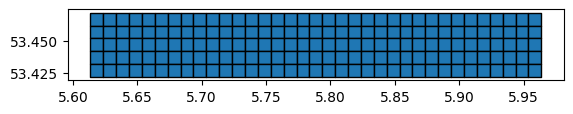

In [ ]:
gpd.GeoDataFrame(grid.copy()).plot(edgecolor='black')

Now let's make sure we georeference the data and convert it to **EPSG:3857** (the same as the Flickr data when plotting).

In [ ]:
grid = gpd.GeoDataFrame(grid.copy())
grid.crs = 'epsg:4326'
grid = grid.to_crs(epsg=3857)

To very efficiently find overlap between two geospatial databases, we make use of spatial queries. You can read more about the function we are using [here](https://pygeos.readthedocs.io/en/latest/strtree.html) and about R-tree (the approach for very efficienet spatial queries) [here](https://en.wikipedia.org/wiki/R-tree). This is one way of doing it - later you will also see how this is done using built-in GeoPandas functions - but this is the technology behind it.

We start with building the tree from our photos. We want to quickly see how many are within each grid cell.

In [ ]:
tree = shapely.STRtree(gdf_unique.loc[gdf_unique.nature=='yes'].geometry)

And now we can use the apply function to look for each of our grid how many photos are taken within each grid cell.

In [ ]:
grid['nature'] = grid.geometry.apply(lambda x: len(tree.query(x,predicate='contains_properly')))

Finally, we can plot it:

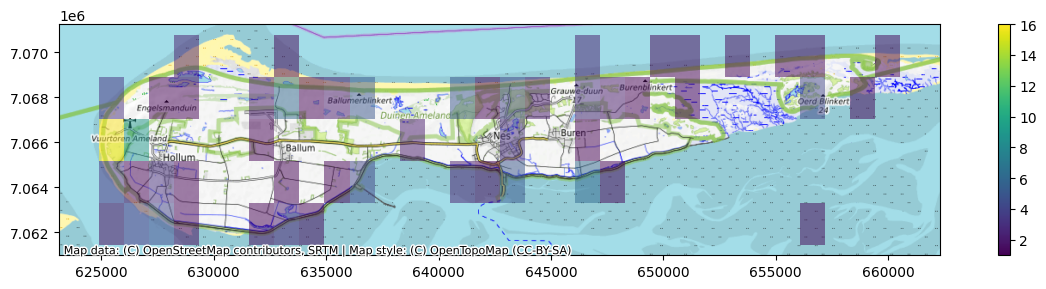

In [ ]:
grid = grid.loc[grid.nature > 0]
grid.reset_index(drop=True,inplace=True)

ax = grid.plot(column='nature',figsize=(15, 3),legend=True,alpha=0.5)
cx.add_basemap(ax, source=cx.providers.OpenTopoMap, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.

#ax.set_title("")

<b>Question 6: Describe the results of the aggregation through using the grid-based approach. Are you already able to identify some areas that seem to be most preferred? Can you identify them by using, for example, Google Maps? Does it surprise you?</b>

(There's some issues with deprecation in Pandas in the next section. This code stops some spammy outputs)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## K-Means clustering
Grid-based aggregation such as performed above finds spatial hotspots. However, the approach above only considers two variables: latitude, and longitude. We can do explore more of the data by using <mark>unsupervised learning</mark> methods such as <mark>K-Means clustering</mark>. In unsupervised learning we don't use labels. That is, we don't have examples to learn from. Instead, our minimization objective is to find similarities between datapoints. In the case of K-Means, this means minimizing the intra-group variance, while maximizing extra-group variance. In simple terms, we want points that are similar to get a value that is more alike to those that have nothing in common.

Specifically, in K-Means we specify the number of <mark>clusters</mark> that we want to assign points to. When initialized, the distance to all randomly-initialized cluster centroids is calculated. Then, the model iterates as follows:
1.   The new cluster centroid is calculated over all points where this cluster is the closest centroid to.
2.   The distance to all cluster centroids is re-calculated, and points are re-assigned depending on their distance to the updated centroids.

Step 1 and 2 are repeatedly performed, each execution of which we call an <mark>iteration</mark>. Each iteration in this process effectively minimizes the squared sum of distances for each centroid, thereby minimizing the intra-group variance while maximizing extra-group variance. Once a certain number of iterations is reached, or once an alternative objective is reached (e.g. the sum of squared distances no longer decreases significantly), then the model is <mark>converged</mark>, meaning it has concluded fitting.

As you can probably tell, the name is derived from the fact that we initialize a total of K means (<- centroids). See below for an example of how this looks.

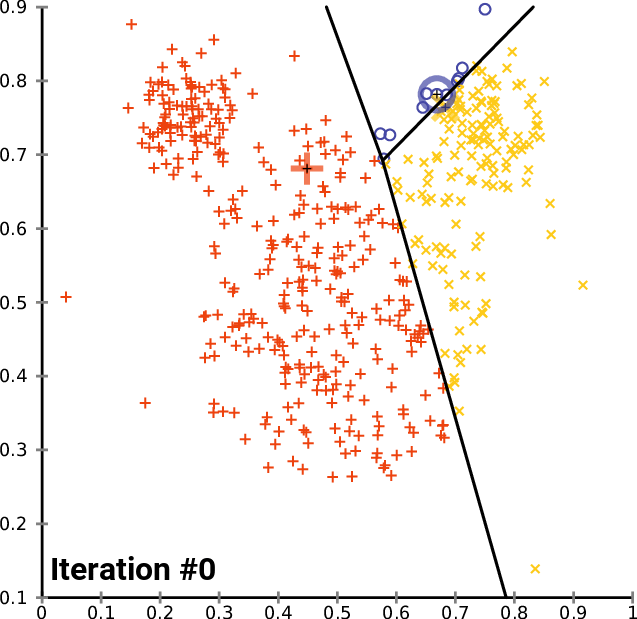

(Figure courtesy of [Wikimedia](https://commons.wikimedia.org/wiki/File:K-means_convergence.gif))

As you can tell from the above, we need numerical values for all of our variables. We already have some variables to work with, but let's add land use at each point to the dataframe first, and transform all our variables so that we can use them for the K-Means algorithm.

### Adding land use data
Let's quickly add some land use data so we can give our K-Means algorithm some more useful variables to work with, beyond what's already in the dataframe.

Next, we make a bounding box to limit the extent of the data we're querying

In [ ]:
# Get the bounding box coordinates for all of our images in EPSG:28992 format
converted_gdf = gdf.to_crs(28992)
bbox = list(converted_gdf.total_bounds)
print(bbox)

[170048.22796566627, 604297.6778623887, 192423.01071488988, 609454.430915703]


Now, we will perform a call to a "web feature service" (WFS), which is a web endpoint that serves geometries. Simply put, it's a specialized API that serves vector data. Here, we will load a land use layer that contains very detailed descriptions of land use.

In [ ]:
def get_wfs_variables(wfs_url, bounding_box):
    # Connect to the WFS service
    wfs = WebFeatureService(url=wfs_url, version='2.0.0')

    # List available layers
    print("layer names:", list(wfs.contents))
    layer = list(wfs.contents)[0] # Select the only layer in here, the grid square statistics

    # Query the API to retrieve land use polygons
    response = wfs.getfeature(typename=layer, bbox=bounding_box, maxfeatures=1e6, outputFormat='application/json')

    # Make a dataframe out of the response
    data = json.loads(response.read())
    wfs_dataframe = gpd.GeoDataFrame.from_features(data["features"])
    print("available variables:", len(list(wfs_dataframe.keys())))
    print("total features:", len(wfs_dataframe))
    wfs_dataframe.head()

    # Convert coordinate reference systems to world geodetic
    wfs_dataframe.set_crs(epsg=28992, inplace=True)
    wfs_dataframe.to_crs(epsg=4326, inplace=True)

    return wfs_dataframe

In [ ]:
wfs_dataframe = get_wfs_variables('https://service.pdok.nl/cbs/bestandbodemgebruik/2017/wfs/v1_0?request=getCapabilities&service=WFS', bbox)

layer names: ['bestandbodemgebruik:BBG2017']
available variables: 4
total features: 244


Now let's look at the specific categories that came back.
The descriptions are in Dutch unfortunately, but you can run them through a translator to get a gist of what they are.

In [ ]:
set(wfs_dataframe['categorie'])

{'Bedrijfsterrein',
 'Begraafplaats',
 'Bos',
 'Bouwterrein',
 'Dagrecreatief terrein',
 'Delfstofwinplaats',
 'Detailhandel en horeca',
 'Hoofdweg',
 'Noordzee',
 'Open droog natuurlijk terrein',
 'Open nat natuurlijk terrein',
 'Openbare voorziening',
 'Overig agrarisch terrein',
 'Overig binnenwater',
 'Park en plantsoen',
 'Semi-verhard overig terrein',
 'Sociaal-culturele voorziening',
 'Sportterrein',
 'Stortplaats',
 'Verblijfsrecreatief terrein',
 'Vliegveld',
 'Waddenzee, Eems & Dollard',
 'Water met recreatieve functie',
 'Woongebied'}

Now we can make some specialized
<mark>one-hot encoded</mark> variables (ones where true, zeroes where false), simplifying the land use to a few simple categories:

In [ ]:
# Tilde (~) is for set negation, in other words 'all that do not satisfy this condition'.
wfs_dataframe['is_built_up'] = (~wfs_dataframe['categorie'].isin(['Bos',
                                                                 'Water met recreatieve functie',
                                                                 'Open droog natuurlijk terrein',
                                                                 'Open nat natuurlijk terrein',
                                                                 'Park en plantsoen',
                                                                 'Overig binnenwater',
                                                                 'Noordzee',
                                                                 'Waddenzee, Eems & Dollard',
                                                                 'Overig agrarisch terrein'])).astype(int)

wfs_dataframe['is_aquatic'] = (wfs_dataframe['categorie'].isin(['Water met recreatieve functie',
                                                                 'Open nat natuurlijk terrein',
                                                                 'Overig binnenwater',
                                                                 'Noordzee',
                                                                 'Waddenzee, Eems & Dollard'])).astype(int)

wfs_dataframe['is_natural'] = (wfs_dataframe['categorie'].isin(['Bos',
                                                                 'Open droog natuurlijk terrein',
                                                                 'Overig agrarisch terrein'])).astype(int)

**Question 7: Why can't we use the text strings as is, why should they be converted to one-hot encoded classes?**

We can then join the dataframe with new variables onto the existing one:

In [ ]:
# Perform a 'left join' spatial intersection operation to attach the new variables onto our dataframe
# Features are joined based on which polygon each point is located within.
gdf_km = gpd.sjoin(gdf, wfs_dataframe, how="left", op="intersects")

Let's also transform the existing `nature` column to a binary format:

In [ ]:
gdf_km['has_nature_tags'] = (gdf_km['nature'] == 'yes').astype(int)

We can also make some features out of the timestamps we have for all images. In the box below, do the following:
1.   Make a column which contains the year relative to the starting year
2.   Convert the time column to hours of the day (in hours and with minutes represented as decimal values behind the comma)
3.   Convert that time-of-day such that they are cyclical
4.   Convert months to cyclical data as well

The first two should be fairly clear, but what should you do for step 3 and 4? Here's a hint: think circles, think trigonometry!

In [ ]:
# Get relative year in which the img was taken

# Extract time by converting time part

# Convert time-of-day to cyclical ranges

# Convert months to cyclical ranges

# Add all variables into the dataframe

   sin_time  cos_time
0 -0.609050 -0.793132
1 -0.775266 -0.631635
2 -0.485000 -0.874514
3  0.481435 -0.876482
4  0.762762 -0.646679


**Question 8: Which solution did you come up with for point 3? Which kinds of problems could arise if we don't transform our data into a cyclical range?**

Finally, let's clean the dataframe to contain only the columns we want to retain.

In [ ]:
columns_to_retain = ['latitude', 'longitude', 'rel_yr', 'month', 'has_nature_tags',  'sin_time', 'cos_time', 'is_built_up', 'is_aquatic', 'is_natural']
gdf_km_cleaned = gdf_km[columns_to_retain]
gdf_km_cleaned.head(5)

,latitude,longitude,rel_yr,month,has_nature_tags,sin_time,cos_time,is_built_up,is_aquatic,is_natural
0,53.449381,5.623358,45,8,0,-0.609050,-0.793132,0,0,1
1,53.460082,5.777918,45,9,0,-0.775266,-0.631635,0,0,1
2,53.445075,5.613788,45,8,1,-0.485000,-0.874514,0,0,1
3,53.450711,5.631969,45,9,0,0.481435,-0.876482,0,0,1
4,53.449844,5.634163,45,9,0,0.762762,-0.646679,1,0,0


Perfect, now that we have a set of variables we can do some clustering to determine similarity in images.

## Performing the clustering

Now that we have our variables set up, let's perform K-Means clustering. We will use the `KMeans` function from SKLearn for this.

However, if you want a fun coding challenge, you can try writing your own algorithm. The logic is quite simple, and in practice you need two FOR loops - one loop to perform iteration, and another to go through all rows to calculate their distances. You need a variable to track the cluster centroids assigned to each row. Give it a go if you're done early!

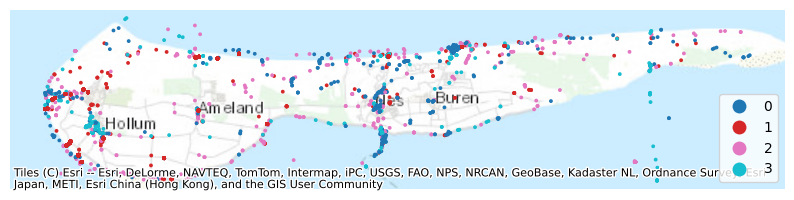

In [ ]:
# Initialize and apply KMeans
num_clusters = 4 # Change this if you want a different number of cluster points
kmeans = KMeans(n_clusters=num_clusters)
gdf['cluster'] = kmeans.fit_predict(gdf_km_cleaned)

## Plot results
gdf_to_plot = gdf.to_crs(3857)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame, coloring by the 'cluster' column
gdf_to_plot.plot(column='cluster', categorical=True, legend=True, cmap='tab10', ax=ax, markersize=3)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# Add a basemap (e.g., OpenTopoMap)
cx.add_basemap(ax, zoom=11, source=cx.providers.Esri.WorldTopoMap)

# Show the plot
plt.show()

Let's try to make some more of some of these clusters by looking at their statistics in aggregate:

In [ ]:
# Group by the 'cluster' column and calculate mean for each group
gdf_km_cleaned['cluster'] = gdf['cluster']
cluster_stats = gdf_km_cleaned.groupby('cluster').mean()

# Display the result
print(cluster_stats)

          latitude  longitude     rel_yr     month  has_nature_tags  sin_time  \
cluster                                                                         
0        53.452325   5.766241  39.799663  9.202020         0.106061 -0.342016   
1        53.445472   5.663029  44.930083  8.924310         0.068634 -0.096092   
2        53.447897   5.742256  42.290323  5.983022         0.213922 -0.400413   
3        53.458392   5.770688  38.639861  5.815698         0.024625 -0.109340   

         cos_time  is_built_up  is_aquatic  is_natural  
cluster                                                 
0       -0.700324     0.260943    0.196970    0.542088  
1       -0.826509     0.219051    0.079217    0.701732  
2       -0.428642     0.292020    0.246180    0.461800  
3       -0.818846     0.043093    0.016160    0.940746  


<ipython-input-51-7b7d4269809f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_km_cleaned['cluster'] = gdf['cluster']


⚠️ Take your time and play around with the following:
*   The number of clusters
*   The variables used - try to define your own extra variables to use!
*   Plotting of variables - e.g. try box plots - does it help to make sense of the clusters?

<b>Question 9: Describe the number of clusters, variables, and visualization methods that were most insightful for you. What helped most, which conclusions can you draw from your best attempt? What have you learned from the exercise?</b>



## Wrapping up
As you can tell from the notebook - and as you probably know from your own professional experience - working with real-world data is messy. Rarely ever is data in the right format, and often you want extra information that isn't already included. Hopefully this notebook has given you some insights into methods for accessing data, and ways in which you can manipulate this data for further analyses.

This tutorial has also given you some hands-on experience with clustering and aggregation methods. As you can tell from the last question, these methods can be very useful, but also opaque and hard to understand. Choosing the right variables is important, and it is not always clear why certain data points belong in certain clusters. Moreover, the number of clusters is arbitrary, and while there are some metrics to test the *'goodness of fit'* (e.g. Calinski-Harabasz Index, Davies-Bouldin Index), it is remains an involved process of trial and error. Methods exist which automatically select the choice of K (e.g. DBSCAN), but these methods aren't guaranteed to make sense either. As you can tell, clustering is an involved matter, and making sense of clustered results can be a difficult task. Despite this, clustering is often used to make sense of results where no explicit labels exist. Hopefully you can find ways to apply it in your own work!